In [1]:
import os, random
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from scipy.spatial import distance
# from torchsummary import summary
import wandb
from lstm_class import LSTM_Single_Layer

In [2]:
def check_prox(a, b, threshhold):
    """returns 1 if the proximity between two points is <= a defined threshold
    else, returns 0"""
    #get distance from a to b
    delta_x = np.abs(a[0] - b[0])
    delta_y = np.abs(a[1] - b[1])
    dist = np.sqrt(np.square(delta_x) + np.square(delta_y))

    #if dist <= threshold, 1 else 0
    if(dist <= threshhold):
        return 1
    else:
        return 0

In [3]:
def log(epoch, step, loss, real_x, real_y, pred_x, pred_y, map):
    
    # Create path plots
    real, ax1 = plt.subplots()
    fake, ax2 = plt.subplots()
    ax1.imshow(map)
    ax2.imshow(map)
    ax1.plot(real_x, real_y, 'ro-', ms=4) # create plot of real path
    ax2.plot(pred_x, pred_y, 'ro-', ms=4) # create plot of NN output

    wandb.log({
        'epoch': epoch,
        'step': step,
        'loss': loss,
        'real': real,
        'fake': fake
    })
    real.clear()
    fake.clear()
    plt.close('all')

In [4]:
class PathsDataset(torch.utils.data.Dataset):
    # init the dataset, shape = L x W
    def __init__(self, gen_dir, transform=None, shape = (100,100), device='cpu', stop_after=500):
        self.device = device
        self.maps_and_paths = []

        num_maps = 0
        for directory in tqdm(os.listdir(gen_dir)):
            num_maps += 1
            dir_path = os.path.join(gen_dir, directory)
            sequence = []

            # open map file:
            with open(f"{dir_path}/{directory}.txt", 'r') as f:
                self.flat_map = np.loadtxt(f)
                self.map = np.asarray(self.flat_map, dtype=np.float32).reshape(shape[0],shape[1])

            # add map to sequence array:
            sequence.append(torch.tensor(self.map))

            path_dir = f"{dir_path}/paths/"
            num_paths = 0
            for filename in os.listdir(path_dir):
                num_paths += 1
                with open(os.path.join(path_dir, filename), 'r') as f: # open in readonly mode
                    path_points_list = [] # a list to hold each point in a path
                    self.flat_path = np.loadtxt(f) # load in the flat path from file
                    self.path = np.asarray(self.flat_path, dtype=np.float32).reshape(len(self.flat_path)//2,2) #unflatten the path from the file
                    for point in self.path:
                        x = point[0]
                        y = point[1]
                        this_point = [x, y]
                        path_points_list.append(this_point)

                sequence.append(torch.tensor(path_points_list, dtype=torch.float)[:, :])
                
            self.maps_and_paths.append(sequence)

            if num_maps == stop_after:
                break
        
        self.transform = transform
        print("Done!")

    def __len__(self):
        return len(self.maps_and_paths)

    def __getitem__(self, idx):
        x = self.maps_and_paths[idx]
        if self.transform:
            x = self.transform(x)
        
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# wandb parameters
RECORD_METRICS = True
STEP_LEN = 500
NUM_LAYERS = 1      # !!!!!*** if you want to actually change this you need to do it manually ****!!!!!

# training parameters
BATCH_SIZE = 1      # needs to be 1 since all paths are different lengths (can try padding with zeros too)
LR = 0.00001
NUM_EPOCHS = 1
DROPOUT = 1         #Dropout (yes=1 or no=0)
DROPOUT_P = 0.4     # what % of nodes to drop out (usually 0.2 to 0.5)

# dataset info
DATASET = 'single_30_density'
SUBSET = 'train'
MAP_SHAPE = (64,64)
train_dataset = PathsDataset(gen_dir = f"./env/{DATASET}/{SUBSET}/", shape = MAP_SHAPE, transform=None, device=device, stop_after=10)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# loading map encoder from file
ENCODER_PATH = f"checkpoints/encoder/"
DECODER_PATH = f"checkpoints/decoder/"
LOAD_EPOCH = 29

100%|██████████| 1/1 [00:08<00:00,  8.55s/it]

Done!


In [6]:
GROUP = ''

CONFIG = dict(
    dataset = DATASET,
    subset = SUBSET,

    batch_size = BATCH_SIZE,
    learning_rate = LR,
    dropout = DROPOUT,
    dropout_p = DROPOUT_P,
    num_layers = NUM_LAYERS
)

if RECORD_METRICS:
    run = wandb.init(project='LSTM', entity='aicv-lab', config=CONFIG, group=GROUP)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rmohl (aicv-lab). Use `wandb login --relogin` to force relogin


In [7]:
class Encoder(nn.Module):
    """define encoder class that is used to encode maps
    Note: the encoder must be pre-trained using 'convolutional-auto-encoder.ipynb'"""
    def __init__(self):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 5, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 5, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 5, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),     
            nn.Conv2d(64, 128, 7, stride=2, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(True),  
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return x

In [8]:
# class Decoder(nn.Module):
"""decoder is not used in LSTM"""
#     def __init__(self):
#         super().__init__()

#         self.unflatten = nn.Unflatten(dim=1, 
#         unflattened_size=(128, 1, 1))

#         self.decoder_conv = nn.Sequential(
#             nn.ConvTranspose2d(128, 64, 7, 
#             stride=2, padding=0, output_padding=0),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(64, 32, 5,
#             stride=2, padding=1, output_padding=0),
#             nn.BatchNorm2d(32),
#             nn.ConvTranspose2d(32, 16, 5, 
#             stride=2, padding=1, output_padding=0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(16, 1, 5, 
#             stride=2, padding=1, output_padding=1)
#         )
        
#     def forward(self, x):
#         x = self.unflatten(x)
#         x = self.decoder_conv(x)
#         x = torch.sigmoid(x)
#         return x

'decoder is not used in LSTM'

In [9]:
# create a new encoder
encoder = Encoder()
# decoder = Decoder()

In [10]:
""" loads encoder checkpoint from file"""
checkpoint = torch.load(f'{ENCODER_PATH}epoch-{LOAD_EPOCH}.tar')
encoder.load_state_dict(checkpoint['model_state_dict'])

# checkpoint = torch.load(f'{DECODER_PATH}epoch-{LOAD_EPOCH}.tar')
# decoder.load_state_dict(checkpoint['model_state_dict'])

encoder.to(device)
# decoder.to(device)

encoder.eval()
# decoder.eval()

Encoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [11]:
# creating empty data arrays:
maps = []
train_target_paths = []
train_input_paths = []
train_goal_points = []

for data in train_dataset:

    # add current map to 'maps' array:
    maps.append(data[0].to(device))                         # data[0] will be a map (just how dataloader works)

    # creating empty arrays for current maps' path data:
    curr_map_target_paths = []
    curr_map_input_paths = []
    curr_map_goal_points = torch.Tensor()

    # iterating through each path associated with current map:
    for path in data[1:]:                                   # data[1:] will be an array of paths associated with the data[0] map
        input_path = path[:-1]  # all points except last
        target_path = path[1:]  # all points except first
        goal_point = path[len(path)-1].unsqueeze(0)     # array containing goal point information

        # add input, target, and goal point information to respective arrays:
        curr_map_target_paths.append(torch.Tensor(target_path).to(device))
        curr_map_input_paths.append(torch.Tensor(input_path).to(device))
        curr_map_goal_points = torch.cat((curr_map_goal_points, goal_point), 0)

    # add all path information associated with current map:
    train_target_paths.append(curr_map_target_paths)
    train_input_paths.append(curr_map_input_paths)
    train_goal_points.append(curr_map_goal_points.to(device))

In [12]:
# print(len(train_input_paths))
# print(len(train_target_paths))
# print(len(train_goal_points))

# print(len(test_input_paths))

# map_num = 1

# print(f"path num: {len(train_input_paths[map_num])}")
# # print(train_input_paths[map_num])
# print(len(train_target_paths[map_num]))
# print(len(train_goal_points[map_num]))

In [13]:
# map = maps[0]
# # print(map.device)
# plt.imshow(map.cpu())
# plt.show()

# map_4d = map.unsqueeze(0).unsqueeze(0)
# encoded_map = encoder(map_4d)#.squeeze()
# print(encoded_map.shape)

# # decoded_map = decoder(encoded_map)
# # new_map_2d = decoded_map.squeeze()

# # plt.imshow(new_map_2d.cpu().detach().numpy())
# # plt.show()

In [14]:
# class MyLSTM(nn.Module):
#   # hidden_d - the size of the hidden LSTM layers
#   # map_d - the flattened/encoded map dimension
#   def __init__(self, hidden_d=120, map_d=128, device="cpu"):
#     self.hidden_d = hidden_d
#     self.device = device
#     super(MyLSTM, self).__init__()

#     # hidden layer - encoded map
#     self.lstm_map = nn.LSTMCell(input_size=map_d, hidden_size=self.hidden_d, device=self.device)

#     # hidden layer - current and goal point
#     self.lstm_points = nn.LSTMCell(input_size=4, hidden_size=self.hidden_d, device=self.device)
    
#     # hidden layer - concat #1
#     self.lstm1 = nn.LSTMCell(input_size=self.hidden_d*2, hidden_size=self.hidden_d, device=self.device)

#     self.fc = nn.Linear(self.hidden_d, 2, device=self.device)

#     #dropout
#     self.do = nn.Dropout(p=DROPOUT_P)

#     self.hidden_states = self.init_hidden() # creates a list of empty tensors for cell and hidden states

#   def init_hidden(self):
#     return(
#       [torch.zeros(1, self.hidden_d).to(self.device), # hidden states - encoded map
#       torch.zeros(1, self.hidden_d).to(self.device), # cell states - encoded map
#       torch.zeros(1, self.hidden_d).to(self.device), # hidden states - current and goal point
#       torch.zeros(1, self.hidden_d).to(self.device), # cell states - current and goal point
#       torch.zeros(1, self.hidden_d).to(self.device), # hidden states - concat layer
#       torch.zeros(1, self.hidden_d).to(self.device)] # cell states - concat layer
#     )

#   def forward(self, goal_point, current_point, map):

#     encoded_map_hidden_state = self.hidden_states[0].clone().detach() # clone copies of hidden and cell state maps
#     encoded_map_cell_state = self.hidden_states[1].clone().detach()
#     points_hidden_state = self.hidden_states[2].clone().detach()
#     points_cell_state = self.hidden_states[3].clone().detach()
#     hidden_state_1 = self.hidden_states[4].clone().detach()
#     cell_state_1 = self.hidden_states[5].clone().detach()

#     outputs = [] # create an empty list to hold network output

#     # Concatenate start and goal
#     points = torch.cat([current_point, goal_point], 0).unsqueeze(0)

#     # run the encoded map and concatenated points through the first network layers
#     encoded_map_hidden_state, encoded_map_cell_state = self.lstm_map(map, (encoded_map_hidden_state, encoded_map_cell_state))
#     points_hidden_state, points_cell_state = self.lstm_points(points, (points_hidden_state, points_cell_state))

#     # Concatenate the output from the lstm layer and output from points layer into a single input to the final hidden layer
#     # (note that for LSTMCell layer, the output is the "hidden state map")
#     final_layer_input = torch.cat([encoded_map_hidden_state, points_hidden_state], 1)

#     # feed thorugh the final layer
#     hidden_state_1, cell_state_1 = self.lstm1(final_layer_input, (hidden_state_1, cell_state_1))

#     # (Optional) add dropout before final layer
#     if DROPOUT: hidden_state_1 = self.do(hidden_state_1) # dropout here
      
#     # Last hidden state is passed through a fully connected neural net to get down to two in size (output is next point predicted)
#     output = self.fc(hidden_state_1)	
#     outputs.append(output)

#     outputs = torch.cat(outputs, dim=0)

#     # save the updated cell and hidden state maps
#     self.hidden_states[0] = encoded_map_hidden_state
#     self.hidden_states[1] = encoded_map_cell_state
#     self.hidden_states[2] = points_hidden_state
#     self.hidden_states[3] = points_cell_state
#     self.hidden_states[4] = hidden_state_1
#     self.hidden_states[5] = cell_state_1
    
#     return outputs

LSTM_Single_Layer(
  (lstm_map): LSTMCell(128, 120)
  (lstm_points): LSTMCell(4, 120)
  (lstm1): LSTMCell(240, 120)
  (fc): Linear(in_features=120, out_features=2, bias=True)
  (do): Dropout(p=0.4, inplace=False)
)


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

epoch: 0
Map 0/1


Training paths for current map:   0%|          | 0/100000 [00:00<?, ?it/s]

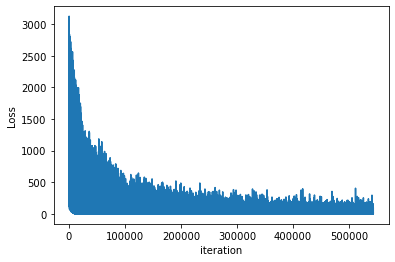

In [15]:
this_lstm = LSTM_Single_Layer(device=device, dropout=DROPOUT, dropout_p=DROPOUT_P)
# print summary
print(this_lstm)
loss = []
criterion = nn.MSELoss()
opt = torch.optim.Adam(this_lstm.parameters(), lr=LR)
for e in tqdm_notebook(range(NUM_EPOCHS), desc = f'Epochs'):

  print(f'epoch: {e}')
  this_lstm.hidden_states = this_lstm.init_hidden() # re-initialize hidden and cell states for each epoch

  for map_num in range(len(maps)):                                          # go through each map
    print(f'Map {map_num}/{len(maps)}')
    encoded_map = encoder(maps[map_num].unsqueeze(0).unsqueeze(0))

    for path_num in tqdm_notebook(range(len(train_input_paths[map_num])), desc = f'Training paths for current map'):                # go through each path
      
      if RECORD_METRICS:
        path_loss = []
        path_pred = []
      
      for point_num in range(len(train_input_paths[map_num][path_num])):   # go through each point
        pred = this_lstm(train_goal_points[map_num][path_num], train_input_paths[map_num][path_num][point_num], encoded_map)[0].squeeze()
        
        if RECORD_METRICS:
          path_pred.append(pred.cpu().detach())
        
        err = criterion(pred, train_target_paths[map_num][path_num][point_num])
        opt.zero_grad()
        err.backward(retain_graph=True)
        opt.step()
        loss.append(err.item())

        if RECORD_METRICS:
          path_loss.append(err.item())

      # Log to WandB
      if RECORD_METRICS and path_num % STEP_LEN == 0:
        path_loss = np.mean(path_loss)

        # Convert items from path lists to ndarrays
        real_x = []
        real_y = []
        for item in train_target_paths[map_num][path_num].cpu().detach():
          real_x.append(item[0])
          real_y.append(item[1])

        pred_x = []
        pred_y = []
        for item in path_pred:
          pred_x.append(item[0])
          pred_y.append(item[1])

        log(e, run.step, path_loss, real_x, real_y, pred_x, pred_y, maps[map_num].cpu())

plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('iteration')
plt.show()

In [16]:
run.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▅▂▃▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch,0
loss,21.87674
step,199


In [17]:
SAVE_PATH = f"checkpoints/lstm/"

torch.save({
            'epoch': e,
            'model_state_dict': this_lstm.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'loss': loss[len(loss)-1],
            'dropout': DROPOUT,
            'dropout_p': DROPOUT_P,
}, f"{SAVE_PATH}epoch-{e}.tar")

goal: [38.0, 52.0], pred: [23.620649337768555, 11.353017807006836]
goal: [38.0, 52.0], pred: [17.090774536132812, 16.534391403198242]
goal: [38.0, 52.0], pred: [16.987789154052734, 24.228605270385742]
goal: [38.0, 52.0], pred: [18.147930145263672, 30.75971031188965]
goal: [38.0, 52.0], pred: [19.73696517944336, 29.971084594726562]
goal: [38.0, 52.0], pred: [22.087142944335938, 32.59544372558594]
goal: [38.0, 52.0], pred: [26.884164810180664, 32.59693145751953]
goal: [38.0, 52.0], pred: [29.69335174560547, 35.94926452636719]
goal: [38.0, 52.0], pred: [26.4200496673584, 37.46169662475586]
goal: [38.0, 52.0], pred: [32.397789001464844, 49.2530403137207]
goal: [38.0, 52.0], pred: [34.259986877441406, 54.13115310668945]
goal: [38.0, 52.0], pred: [38.452659606933594, 54.43952941894531]
threshhold met, exiting


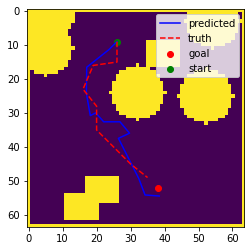

goal: [20.0, 45.0], pred: [35.26504135131836, 52.36158752441406]
goal: [20.0, 45.0], pred: [30.02177619934082, 45.34854507446289]
goal: [20.0, 45.0], pred: [20.34140396118164, 38.472103118896484]
goal: [20.0, 45.0], pred: [22.527244567871094, 45.222015380859375]
threshhold met, exiting


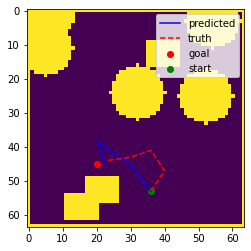

goal: [28.0, 57.0], pred: [35.93181610107422, 40.57218551635742]
goal: [28.0, 57.0], pred: [31.602678298950195, 40.73333740234375]
goal: [28.0, 57.0], pred: [25.17580223083496, 40.81173324584961]
goal: [28.0, 57.0], pred: [27.085681915283203, 43.444435119628906]
goal: [28.0, 57.0], pred: [30.99960708618164, 53.01971435546875]
goal: [28.0, 57.0], pred: [31.892364501953125, 56.368221282958984]
goal: [28.0, 57.0], pred: [35.151302337646484, 62.376487731933594]
goal: [28.0, 57.0], pred: [30.916112899780273, 61.37201690673828]
goal: [28.0, 57.0], pred: [28.719308853149414, 54.93163299560547]
threshhold met, exiting


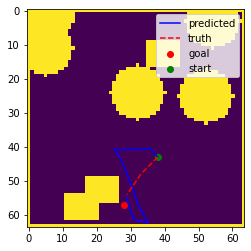

goal: [33.0, 36.0], pred: [32.08218765258789, 18.465063095092773]
goal: [33.0, 36.0], pred: [23.47019386291504, 19.282329559326172]
goal: [33.0, 36.0], pred: [20.028812408447266, 20.908552169799805]
goal: [33.0, 36.0], pred: [20.865459442138672, 27.312427520751953]
goal: [33.0, 36.0], pred: [21.545406341552734, 30.434860229492188]
goal: [33.0, 36.0], pred: [23.514169692993164, 33.08987045288086]
goal: [33.0, 36.0], pred: [27.188739776611328, 38.04198455810547]
goal: [33.0, 36.0], pred: [34.23863220214844, 39.6330451965332]
goal: [33.0, 36.0], pred: [32.537147521972656, 42.39624786376953]
goal: [33.0, 36.0], pred: [33.29642105102539, 39.66340255737305]
goal: [33.0, 36.0], pred: [27.724397659301758, 33.931251525878906]
goal: [33.0, 36.0], pred: [23.066814422607422, 32.670875549316406]
goal: [33.0, 36.0], pred: [24.96517562866211, 32.41508102416992]
goal: [33.0, 36.0], pred: [29.368261337280273, 34.826351165771484]
goal: [33.0, 36.0], pred: [31.276248931884766, 34.417152404785156]
threshh

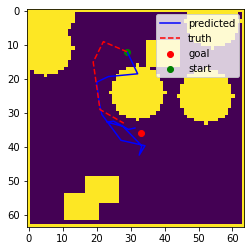

goal: [22.0, 4.0], pred: [43.54802322387695, 39.67328643798828]
goal: [22.0, 4.0], pred: [35.983192443847656, 36.67327117919922]
goal: [22.0, 4.0], pred: [28.414735794067383, 38.08538818359375]
goal: [22.0, 4.0], pred: [19.81687355041504, 27.405460357666016]
goal: [22.0, 4.0], pred: [17.411081314086914, 21.73843765258789]
goal: [22.0, 4.0], pred: [15.963315963745117, 13.697978973388672]
goal: [22.0, 4.0], pred: [19.545204162597656, 9.54404354095459]
goal: [22.0, 4.0], pred: [18.825698852539062, 4.692102432250977]
goal: [22.0, 4.0], pred: [21.985042572021484, 3.5347683429718018]
threshhold met, exiting


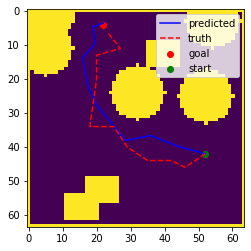

goal: [23.0, 19.0], pred: [19.079301834106445, 36.20543670654297]
goal: [23.0, 19.0], pred: [16.43010711669922, 25.729183197021484]
goal: [23.0, 19.0], pred: [16.69532585144043, 18.382883071899414]
goal: [23.0, 19.0], pred: [19.951908111572266, 16.584178924560547]
goal: [23.0, 19.0], pred: [21.39055061340332, 17.087608337402344]
threshhold met, exiting


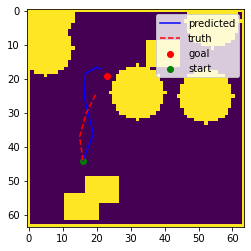

goal: [23.0, 46.0], pred: [45.94204330444336, 51.42975997924805]
goal: [23.0, 46.0], pred: [36.83991622924805, 51.95002365112305]
goal: [23.0, 46.0], pred: [31.54596519470215, 47.32881546020508]
goal: [23.0, 46.0], pred: [27.82923698425293, 42.027442932128906]
goal: [23.0, 46.0], pred: [21.92658042907715, 45.55842208862305]
threshhold met, exiting


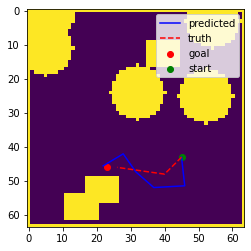

goal: [20.0, 27.0], pred: [22.18671417236328, 6.7856764793396]
goal: [20.0, 27.0], pred: [17.763690948486328, 11.68807315826416]
goal: [20.0, 27.0], pred: [16.96977424621582, 17.369569778442383]
goal: [20.0, 27.0], pred: [17.786100387573242, 23.46205711364746]
goal: [20.0, 27.0], pred: [15.76156997680664, 24.584299087524414]
goal: [20.0, 27.0], pred: [17.709415435791016, 28.014307022094727]
threshhold met, exiting


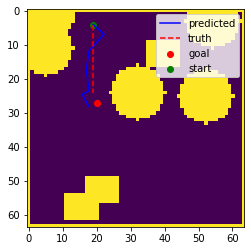

goal: [19.0, 36.0], pred: [19.974384307861328, 13.692989349365234]
goal: [19.0, 36.0], pred: [18.243322372436523, 20.060617446899414]
goal: [19.0, 36.0], pred: [19.420761108398438, 28.3696346282959]
goal: [19.0, 36.0], pred: [18.304555892944336, 32.3213996887207]
goal: [19.0, 36.0], pred: [21.589366912841797, 36.98732376098633]
threshhold met, exiting


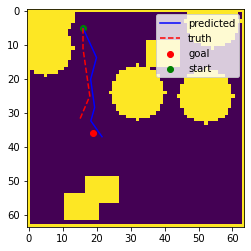

goal: [5.0, 43.0], pred: [26.3773193359375, 39.89494323730469]
goal: [5.0, 43.0], pred: [16.913904190063477, 34.624855041503906]
goal: [5.0, 43.0], pred: [11.754704475402832, 37.87641525268555]
goal: [5.0, 43.0], pred: [6.186478614807129, 39.107208251953125]
goal: [5.0, 43.0], pred: [12.45748233795166, 48.99171829223633]
goal: [5.0, 43.0], pred: [5.8869404792785645, 40.80610275268555]
threshhold met, exiting


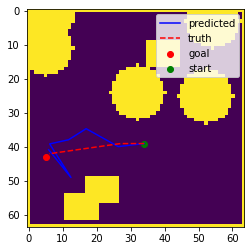

In [18]:
# Test performance on the training dataset

num_points = 30 # num points to predict for each path
maps_to_gen = 1
paths_to_gen = 10 # num training paths to plot

states = torch.zeros(1, this_lstm.hidden_d).to(this_lstm.device)

for map_idx in range(maps_to_gen):
    map = maps[map_idx]
    for path_idx in range(paths_to_gen):
        start_point = train_input_paths[map_idx][path_idx][0]
        generated_pts = []
        with torch.no_grad():
            
            # add start point:
            generated_pts.append(start_point.cpu().detach().numpy().tolist())
            prev_pred = start_point

            # predict other points:
            for i in range(num_points):
                pred = this_lstm(train_goal_points[map_idx][path_idx], prev_pred, encoded_map).squeeze()
                prev_pred = pred
                generated_pts.append(pred.cpu().detach().numpy().tolist())
                print(f'goal: {train_goal_points[map_idx][path_idx].cpu().detach().numpy().tolist()}, pred: {pred.cpu().detach().numpy().tolist()}')
                if check_prox(train_goal_points[map_idx][path_idx].cpu().detach().numpy().tolist(), pred.cpu().detach().numpy().tolist(), 3):  # stop predicting if close to goal
                    print("threshhold met, exiting")
                    break

        xs = []
        ys = []

        for x,y in generated_pts:
            xs.append(x)
            ys.append(y)

        plt.imshow(map.cpu())
        # plt.plot(xs, ys, color='k', label = "input")
        plt.plot(xs, ys, color='b', label = "predicted")
        plt.plot(train_input_paths[map_idx][path_idx][:,0].cpu(), train_input_paths[map_idx][path_idx][:,1].cpu(), color='r', label = "truth", linestyle='dashed')
        plt.scatter(train_goal_points[map_idx][path_idx][0].cpu(), train_goal_points[map_idx][path_idx][1].cpu(), c='r', label='goal')
        plt.scatter(start_point[0].cpu(), start_point[1].cpu(), c='g', label='start')
        plt.legend()
        plt.show()

reached goal, exiting


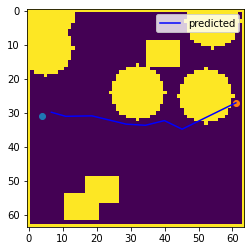

reached goal, exiting


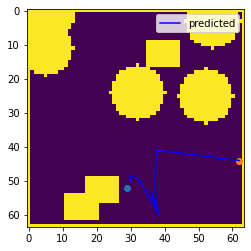

reached goal, exiting


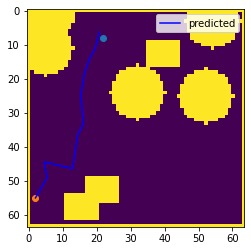

reached goal, exiting


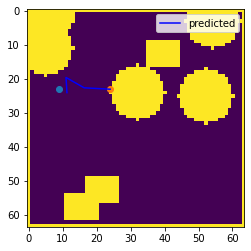

reached goal, exiting


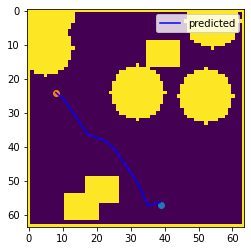

reached goal, exiting


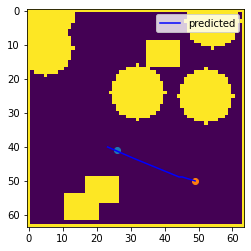

reached goal, exiting


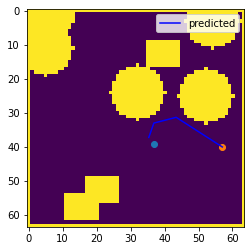

reached goal, exiting


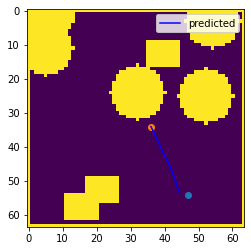

reached goal, exiting


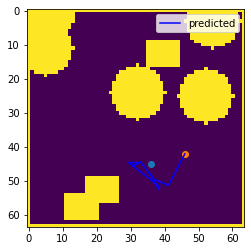

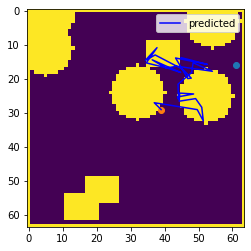

reached goal, exiting


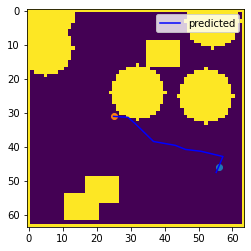

reached goal, exiting


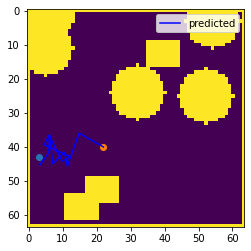

reached goal, exiting


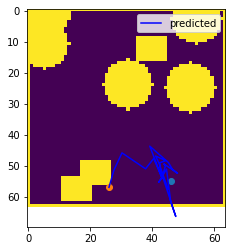

reached goal, exiting


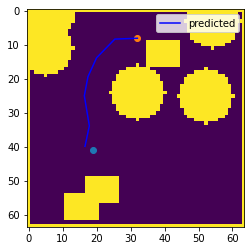

reached goal, exiting


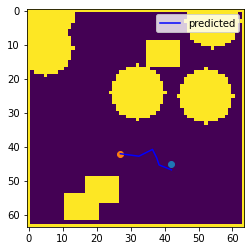

reached goal, exiting


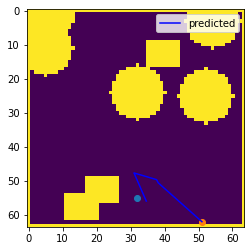

reached goal, exiting


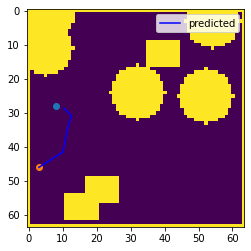

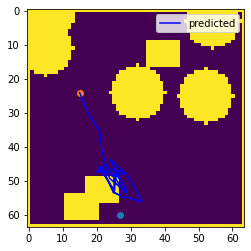

reached goal, exiting


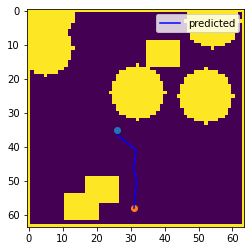

reached goal, exiting


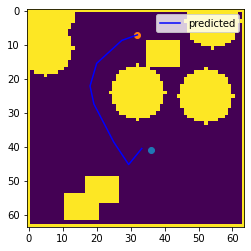

In [19]:
# Test performance on unseen/eval maps

# flat_map = np.loadtxt(f"./env/{MAP_NAME}/{MAP_NAME}.txt", skiprows=2)                                                   # load in the flat path from file
# flat_map = np.loadtxt(f"./env/100_maps_20p_coverage/{SUBSET}/map_6/map_2.txt")
flat_map = np.loadtxt(f"./env/{DATASET}/eval/map_0/map_0.txt")
map = torch.tensor(np.asarray(flat_map, dtype=int).reshape(MAP_SHAPE[0], MAP_SHAPE[1])).to(device, dtype=torch.float)     # unflatten the map from the file
map_4d = map.unsqueeze(0).unsqueeze(0)
encoded_map = encoder(map_4d)

# testing to see if it follows new paths:
non_obs_coords = np.transpose(torch.flipud(np.argwhere(map.cpu()==0)))
# print(non_obs_coords)

start_points_list = []
coords_list = []

num_points = 30 # num points to predict for each path
paths_to_gen = 20 # num paths to generate

states = torch.zeros(1, this_lstm.hidden_d).to(this_lstm.device)

for x in range(paths_to_gen):
    start_point = random.choice(non_obs_coords).float().to(device)
    goal_point = random.choice(non_obs_coords).float().to(device)

    points = []
    with torch.no_grad():
        pred = start_point
        points.append(pred.cpu().detach().numpy().tolist())
        for point in range(num_points):
            pred = this_lstm(goal_point, pred, encoded_map).squeeze()
            points.append(pred.cpu().detach().numpy().tolist())
            if check_prox(goal_point.cpu().detach().numpy().tolist(), pred.cpu().detach().numpy().tolist(), 3): # stop predicting if close to goal
                print("reached goal, exiting")
                break

    xs = []
    ys = []
    for x,y in points:
        xs.append(x)
        ys.append(y)

    plt.imshow(map.cpu())
    plt.plot(xs, ys, color='b', label = "predicted")
    plt.scatter(goal_point[0].cpu(), goal_point[1].cpu())
    plt.scatter(start_point[0].cpu(), start_point[1].cpu())
    plt.legend()
    plt.show()